In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import os

import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
    
import pandas as pd

In [2]:
# Controlla le GPU disponibili
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Numero di GPU disponibili: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome GPU: {gpu.name}")
else:
    print("Nessuna GPU disponibile")

Numero di GPU disponibili: 1
Nome GPU: /physical_device:GPU:0


In [3]:
x = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_images.npy")
y = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_labels.npy")

#creazione dei vari dataset
seed = 1999
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

#creazione validation set e train set
x_valid_images = train_images[1000:]/255.
x_valid_labels = train_labels[1000:]
x_train_images = train_images[:1000]/255.
x_train_labels = train_labels[:1000]

#normalizzazione anche del test set
test_images = test_images/255.

print(len(x_train_images), len(x_valid_images), len(train_images))

1000 3708 4708


5232 5232


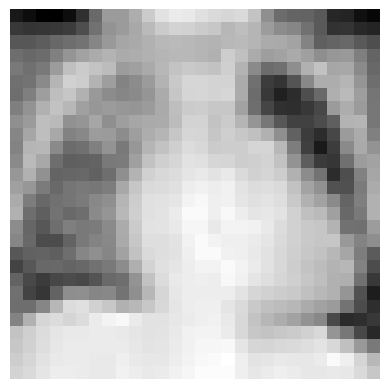

[1]


In [4]:
print(len(x), len(y))
plt.imshow(x_train_images[0], cmap='gray')
plt.axis('off')
plt.show()
print(y[0])

## Random Forest

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [6]:
x_train_flat = x_train_images.reshape(x_train_images.shape[0], -1)
x_valid_flat = x_valid_images.reshape(x_valid_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# Creazione del modello di Random Forest
rf = RandomForestClassifier(random_state=42) # seed per rendere l'analisi ripetibile

# Definizione della griglia degli iperparametri
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Creazione della grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Addestramento della grid search
grid_search.fit(x_train_flat, x_train_labels.ravel())

# Migliori iperparametri trovati
print("Best parameters found: ", grid_search.best_params_)

# Valutazione del modello sul validation set
best_rf = grid_search.best_estimator_
valid_predictions = best_rf.predict(x_valid_flat)
accuracy = accuracy_score(x_valid_labels.ravel(), valid_predictions)
print("Validation set accuracy: ", accuracy)

# Valutazione finale sul test set
test_predictions = best_rf.predict(test_flat)
test_accuracy = accuracy_score(test_labels.ravel(), test_predictions)
print("Test set accuracy: ", test_accuracy)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters found:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Validation set accuracy:  0.942017259978425
Test set accuracy:  0.9599236641221374


In [7]:
from sklearn.metrics import classification_report


report_test = classification_report(test_labels.ravel(), test_predictions)
print(report_test)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       132
           1       0.97      0.97      0.97       392

    accuracy                           0.96       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.96      0.96      0.96       524



## Regressione Logistica

In [8]:
# Import delle librerie necessarie per la regressione logistica
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Creazione del modello di Logistic Regression
# Utilizzando Pipeline per standardizzare i dati e applicare la regressione logistica
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Standardizzazione dei dati
    ('logreg', LogisticRegression(random_state=42, max_iter=100))
])

# Definizione della griglia degli iperparametri per la regressione logistica
param_grid_logreg = [
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['liblinear'],
     'logreg__penalty': ['l1', 'l2']},
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['saga'],
     'logreg__penalty': ['l1', 'l2', 'elasticnet'],
     'logreg__l1_ratio': [0.5]},  # l1_ratio è richiesto per elasticnet
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
     'logreg__penalty': ['l2']}
]
# Creazione della grid search
grid_search_logreg = GridSearchCV(estimator=pipe, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=3)

In [9]:
# Addestramento della grid search
grid_search_logreg.fit(x_train_flat, x_train_labels.ravel())

# Migliori iperparametri trovati
print("Best parameters found for Logistic Regression: ", grid_search_logreg.best_params_)

# Valutazione del modello sul validation set
best_logreg = grid_search_logreg.best_estimator_
valid_predictions_logreg = best_logreg.predict(x_valid_flat)
accuracy_logreg = accuracy_score(x_valid_labels.ravel(), valid_predictions_logreg)
print("Validation set accuracy for Logistic Regression: ", accuracy_logreg)

# Valutazione finale sul test set
test_predictions_logreg = best_logreg.predict(test_flat)
test_accuracy_logreg = accuracy_score(test_labels.ravel(), test_predictions_logreg)
print("Test set accuracy for Logistic Regression: ", test_accuracy_logreg)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found for Logistic Regression:  {'logreg__C': 1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Validation set accuracy for Logistic Regression:  0.9492988133764833
Test set accuracy for Logistic Regression:  0.9484732824427481


In [10]:
report_test_logreg = classification_report(test_labels.ravel(), test_predictions_logreg)
print(report_test_logreg)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       132
           1       0.96      0.97      0.97       392

    accuracy                           0.95       524
   macro avg       0.93      0.93      0.93       524
weighted avg       0.95      0.95      0.95       524



## CNN

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
import random

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42)
con_init = keras.initializers.GlorotUniform(seed=42)

CNN_lenet = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1), kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Conv2D(20, kernel_size=(5, 5), activation='relu', kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dense(128, activation='relu', kernel_initializer=init),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
32/32 [==============================] - 4s 12ms/step - loss: 0.5597 - accuracy: 0.7230 - val_loss: 0.4675 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 0s 6ms/step - loss: 0.3164 - accuracy: 0.8610 - val_loss: 0.2169 - val_accuracy: 0.9102
Epoch 3/300
32/32 [==============================] - 0s 5ms/step - loss: 0.2147 - accuracy: 0.9100 - val_loss: 0.1959 - val_accuracy: 0.9237
Epoch 4/300
32/32 [==============================] - 0s 6ms/step - loss: 0.1752 - accuracy: 0.9290 - val_loss: 0.1850 - val_accuracy: 0.9264
Epoch 5/300
32/32 [==============================] - 0s 6ms/step - loss: 0.1912 - accuracy: 0.9190 - val_loss: 0.1898 - val_accuracy: 0.9264
Epoch 6/300
32/32 [==============================] - 0s 5ms/step - loss: 0.1717 - accuracy: 0.9350 - val_loss: 0.2360 - val_accuracy: 0.8959
Epoch 7/300
32/32 [==============================] - 0s 5ms/step - loss: 0.1899 - accuracy: 0.9260 - val_loss: 0.1906 - val_accuracy: 0.9264
Epoch 8/300


In [6]:
#test set
CNN_lenet.evaluate(test_reshaped, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9542


[0.11366520076990128, 0.9541984796524048]

In [7]:
CNN_lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               128256    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

## CNN + Dropout

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping

x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42)

CNN_lenet_opt = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1)),
    AveragePooling2D(pool_size=(2, 2),strides=2),        
    Dropout(0.3),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet_opt.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])

Epoch 1/300
32/32 [==============================] - 1s 21ms/step - loss: 0.6126 - accuracy: 0.6980 - val_loss: 0.5332 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 0s 15ms/step - loss: 0.5633 - accuracy: 0.7280 - val_loss: 0.5177 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 0s 11ms/step - loss: 0.5072 - accuracy: 0.7390 - val_loss: 0.4013 - val_accuracy: 0.8371
Epoch 4/300
32/32 [==============================] - 0s 11ms/step - loss: 0.3724 - accuracy: 0.8140 - val_loss: 0.2546 - val_accuracy: 0.9075
Epoch 5/300
32/32 [==============================] - 0s 12ms/step - loss: 0.3103 - accuracy: 0.8690 - val_loss: 0.4999 - val_accuracy: 0.7195
Epoch 6/300
32/32 [==============================] - 1s 16ms/step - loss: 0.2994 - accuracy: 0.8830 - val_loss: 0.2328 - val_accuracy: 0.8932
Epoch 7/300
32/32 [==============================] - 0s 11ms/step - loss: 0.2604 - accuracy: 0.8900 - val_loss: 0.2196 - val_accuracy: 0.9024
Epoch 

In [24]:
#test set
CNN_lenet_opt.evaluate(test_reshaped, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.9695


[0.09581366181373596, 0.9694656729698181]

### CNN + Dropout + Batch Normalization

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, BatchNormalization
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping

# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Costruzione della rete con batch normalization
CNN_lenet_opt_bn = Sequential([
    Conv2D(10, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),

    Conv2D(20, kernel_size=(5, 5)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),

    Flatten(),

    Dense(256, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(128, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(1, activation='sigmoid')
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilazione del modello
CNN_lenet_opt_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history_cnn_lenet_bn = CNN_lenet_opt_bn.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
32/32 [==============================] - 2s 20ms/step - loss: 0.8006 - accuracy: 0.6100 - val_loss: 0.5761 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 0s 12ms/step - loss: 0.5111 - accuracy: 0.7710 - val_loss: 0.5228 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 0s 13ms/step - loss: 0.3680 - accuracy: 0.8500 - val_loss: 0.5207 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 0s 15ms/step - loss: 0.3091 - accuracy: 0.8670 - val_loss: 0.5205 - val_accuracy: 0.7449
Epoch 5/300
32/32 [==============================] - 0s 14ms/step - loss: 0.2810 - accuracy: 0.8890 - val_loss: 0.4868 - val_accuracy: 0.7449
Epoch 6/300
32/32 [==============================] - 0s 16ms/step - loss: 0.2809 - accuracy: 0.8920 - val_loss: 0.4893 - val_accuracy: 0.7449
Epoch 7/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2562 - accuracy: 0.9020 - val_loss: 0.6266 - val_accuracy: 0.7449
Epoch 

In [8]:
#test set
CNN_lenet_opt_bn.evaluate(test_reshaped, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 0.1054 - accuracy: 0.9656


[0.10544075071811676, 0.9656488299369812]

Mentre il dropout sembra aver migliorato leggermente l'accuracy, la Batch Normalization non sembra avere lo stesso effetto, avendo una accuracy sul testing set leggermente più bassa rispetto al modello precedente.

## CNN con blocco Inception

In [19]:
# Funzione per creare un blocco Inception
def single_inception_block(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_single_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # blocco Inception
    x = single_inception_block(inputs, 128)
    
    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    
    # Aggiunta di livelli densi per la classificazione
    init = keras.initializers.HeNormal(seed=42)

    x = layers.Dense(256, activation='relu', kernel_initializer=init)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=init)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1)
input_shape = (28, 28, 1)
CNN_single_inception = create_single_inception_cnn(input_shape)

# Compilazione del modello
CNN_single_inception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
#model.summary()

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history_single_inception = CNN_single_inception.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])



Epoch 1/300
32/32 [==============================] - 3s 45ms/step - loss: 0.5861 - accuracy: 0.7290 - val_loss: 0.5622 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 1s 31ms/step - loss: 0.5841 - accuracy: 0.7290 - val_loss: 0.5697 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 1s 30ms/step - loss: 0.5880 - accuracy: 0.7290 - val_loss: 0.5725 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 1s 29ms/step - loss: 0.5868 - accuracy: 0.7290 - val_loss: 0.5598 - val_accuracy: 0.7449
Epoch 5/300
32/32 [==============================] - 1s 31ms/step - loss: 0.5775 - accuracy: 0.7290 - val_loss: 0.5575 - val_accuracy: 0.7449
Epoch 6/300
32/32 [==============================] - 1s 29ms/step - loss: 0.5770 - accuracy: 0.7290 - val_loss: 0.5599 - val_accuracy: 0.7449
Epoch 7/300
32/32 [==============================] - 1s 30ms/step - loss: 0.5714 - accuracy: 0.7290 - val_loss: 0.5510 - val_accuracy: 0.7449
Epoch 

In [22]:
CNN_single_inception.evaluate(test_images, test_labels)
CNN_single_inception.summary()

17/17 [==============================] - 0s 10ms/step - loss: 0.1405 - accuracy: 0.9504
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 28, 28, 1)    0           input_4[0][0]                    
____

L'idea è quella di costruire una CNN che richiami quella sviluppata da Google (GoogLeNet) andando a sfruttare il blocco transformer. Si opera questa scelta perché una rete del genere ha mostrato ottime prestazioni in passato, e per non dover cercare di ottimizzare il tipo di Pooling e la dimensione dei Kernel, andandone a sfruttare di diverse dimensioni all'interno del blocco Inception.

In [13]:
# Funzione per creare un blocco Inception
def inception_module(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # Primo blocco Inception
    x = inception_module(inputs, 32)
    
    # Secondo blocco Inception
    x = inception_module(x, 64)
    
    # Terzo blocco Inception
    x = inception_module(x, 128)
    
    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Aggiunta di un livello denso per la classificazione
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1) per immagini in scala di grigi
input_shape = (28, 28, 1)
cnn_inception_extended = create_inception_cnn(input_shape)

# Compilazione del modello
cnn_inception_extended.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
#cnn_inception_extended.summary()

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Addestramento del modello
history = cnn_inception_extended.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])


Epoch 1/300
32/32 [==============================] - 4s 79ms/step - loss: 0.5957 - accuracy: 0.7270 - val_loss: 0.5604 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5881 - accuracy: 0.7290 - val_loss: 0.5586 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5765 - accuracy: 0.7290 - val_loss: 0.5424 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5030 - accuracy: 0.7550 - val_loss: 0.3853 - val_accuracy: 0.8012
Epoch 5/300
32/32 [==============================] - 2s 63ms/step - loss: 0.4451 - accuracy: 0.7760 - val_loss: 0.4156 - val_accuracy: 0.8261
Epoch 6/300
32/32 [==============================] - 2s 59ms/step - loss: 0.4044 - accuracy: 0.8150 - val_loss: 0.4500 - val_accuracy: 0.7953
Epoch 7/300
32/32 [==============================] - 2s 58ms/step - loss: 0.3775 - accuracy: 0.8360 - val_loss: 0.3323 - val_accuracy: 0.8525
Epoch 

In [15]:
cnn_inception_extended.evaluate(test_images, test_labels)

17/17 [==============================] - 0s 12ms/step - loss: 0.0869 - accuracy: 0.9656


[0.08685764670372009, 0.9656488299369812]

Best: 0.9695

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pydot

# Visualizzazione della struttura del modello
plot_model(cnn_inception_extended, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## CNN + Inception + Ottimizzazioni

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

def inception_module(x, filters):
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

def create_inception_cnn_dropout(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = inception_module(inputs, 32)
    x = inception_module(x, 64)
    x = inception_module(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

Epoch 1/100
32/32 [==============================] - 4s 69ms/step - loss: 0.6054 - accuracy: 0.7120 - val_loss: 0.5638 - val_accuracy: 0.7449
Epoch 2/100
32/32 [==============================] - 2s 56ms/step - loss: 0.5890 - accuracy: 0.7290 - val_loss: 0.5465 - val_accuracy: 0.7449
Epoch 3/100
32/32 [==============================] - 2s 57ms/step - loss: 0.5820 - accuracy: 0.7290 - val_loss: 0.5426 - val_accuracy: 0.7449
Epoch 4/100
32/32 [==============================] - 2s 58ms/step - loss: 0.5670 - accuracy: 0.7290 - val_loss: 0.5195 - val_accuracy: 0.7449
Epoch 5/100
32/32 [==============================] - 2s 56ms/step - loss: 0.4947 - accuracy: 0.7550 - val_loss: 0.5052 - val_accuracy: 0.7352
Epoch 6/100
32/32 [==============================] - 2s 57ms/step - loss: 0.4690 - accuracy: 0.7700 - val_loss: 0.4386 - val_accuracy: 0.7821
Epoch 7/100
32/32 [==============================] - 2s 59ms/step - loss: 0.4253 - accuracy: 0.7970 - val_loss: 0.3331 - val_accuracy: 0.8460
Epoch 

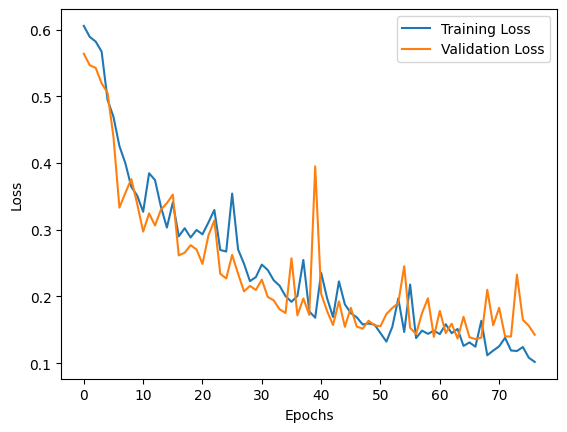

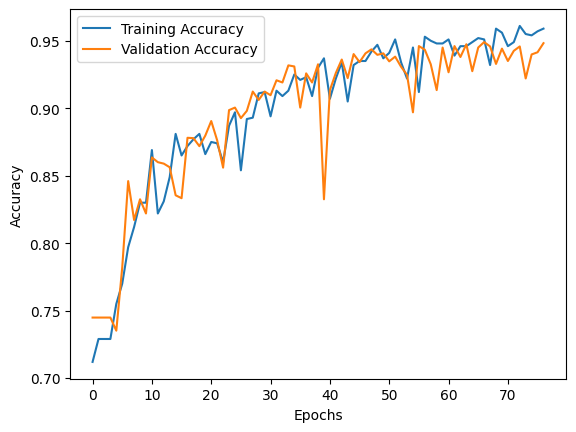

In [10]:
input_shape = (28, 28, 1)
model_opt = create_inception_cnn_dropout(input_shape)

model_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history2 = model_opt.fit(x_train_images, x_train_labels, epochs=100, verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])

# Plotting the training history
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
model_opt.evaluate(test_images, test_labels)

17/17 [==============================] - 0s 8ms/step - loss: 0.1120 - accuracy: 0.9561


[0.11196642369031906, 0.9561068415641785]

Con i dropout a 0.4 il best è 0.9637 (sul testing set obv)

## Data Augmentation sul miglior modello

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import HeNormal

# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Definizione della CNN
CNN_lenet_opt_da = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Configurazione della Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=0,  # no rotazione
    width_shift_range=0.1,  # Spostamento casuale orizzontale del 10% della larghezza
    height_shift_range=0.1,  # Spostamento casuale verticale del 10% dell'altezza
    zoom_range=0.1,  # Zoom casuale del 10%
    horizontal_flip=False,  # Ribaltamento casuale orizzontale
    vertical_flip=False  # Senza ribaltamento casuale verticale
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilazione del modello
CNN_lenet_opt_da.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello con Data Augmentation
history_cnn_lenet_da = CNN_lenet_opt_da.fit(
    datagen.flow(x_reshaped_train, x_train_labels, batch_size=32),
    steps_per_epoch=len(x_reshaped_train) // 32,
    epochs=300,
    validation_data=(x_reshaped_valid, x_valid_labels),
    callbacks=[early_stopping]
)

Epoch 1/300
31/31 [==============================] - 1s 23ms/step - loss: 0.6066 - accuracy: 0.7014 - val_loss: 0.5851 - val_accuracy: 0.7449
Epoch 2/300
31/31 [==============================] - 1s 19ms/step - loss: 0.5906 - accuracy: 0.7345 - val_loss: 0.5552 - val_accuracy: 0.7449
Epoch 3/300
31/31 [==============================] - 0s 15ms/step - loss: 0.5594 - accuracy: 0.7283 - val_loss: 0.4891 - val_accuracy: 0.7449
Epoch 4/300
31/31 [==============================] - 1s 18ms/step - loss: 0.5313 - accuracy: 0.7335 - val_loss: 0.4820 - val_accuracy: 0.7449
Epoch 5/300
31/31 [==============================] - 1s 19ms/step - loss: 0.4826 - accuracy: 0.7366 - val_loss: 0.3991 - val_accuracy: 0.8964
Epoch 6/300
31/31 [==============================] - 1s 19ms/step - loss: 0.4508 - accuracy: 0.7738 - val_loss: 0.3331 - val_accuracy: 0.9083
Epoch 7/300
31/31 [==============================] - 0s 14ms/step - loss: 0.3833 - accuracy: 0.8182 - val_loss: 0.2913 - val_accuracy: 0.8827
Epoch 

In [12]:
# Valutazione del modello sui dati di test
test_loss, test_accuracy = CNN_lenet_opt_da.evaluate(test_reshaped, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

17/17 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9618
Test Loss: 0.10259287059307098
Test Accuracy: 0.9618320465087891
